# Airbnb Models

Alex Bass (ujb3bu)

Kaia Lindberg (pkx2ec)

Elina Ribakova (uvg5bn)


## 5.10 Final Project Ungraded Assignment
At this point in the course, you should be training and evaluating models. Please create a Jupyter Notebook containing a concise summary of your dataset (described in submission instructions).  

At a minimum, the file should include a summary containing:

- Number of records
- Number of columns
- Statistical summary of response variable
- Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
    - Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
- Include up to five helpful graphs

In [1]:
# Imports
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import pyspark.sql.functions as fn

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [91]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

In [3]:
# Start spark session
spark = SparkSession.builder.getOrCreate()


### Users Dataset

In [4]:
# Define schema for data
schema = StructType() \
      .add("id",StringType(),True) \
      .add("date_account_created",StringType(),True) \
      .add("timestamp_first_active",DoubleType(),True) \
      .add("date_first_booking",StringType(),True) \
      .add("gender",StringType(),True) \
      .add("age",DoubleType(),True) \
      .add("signup_method",StringType(),True) \
      .add("signup_flow",IntegerType(),True) \
      .add("language",StringType(),True) \
      .add("affiliate_channel",StringType(),True) \
      .add("affiliate_provider",StringType(),True) \
      .add("first_affiliate_tracked",StringType(),True) \
      .add("signup_app",StringType(),True) \
      .add("first_device_type",StringType(),True) \
      .add("first_browser",StringType(),True) \
      .add("country_destination",StringType(),True)

In [5]:
# Lists of columns
response_col = "country_destination"
id_col = "id"
categorical_cols = ["gender", "signup_method", "language", 
                    "affiliate_channel", "affiliate_provider", "first_affiliate_tracked",
                    "signup_app", "first_device_type", "first_browser"]
numeric_cols = ["timestamp_first_active", "age", "signup_flow", ]
date_cols = ["date_account_created", "date_first_booking"]


In [6]:
# Read data in json format
df = spark.read.option("header",True).csv("train_users_2.csv", schema)


### Sessions Data

In [7]:
# Define schema for data
schema_sessions = StructType() \
      .add("user_id",StringType(),True) \
      .add("action",StringType(),True) \
      .add("action_type",StringType(),True) \
      .add("action_detail",StringType(),True) \
      .add("device_type",StringType(),True) \
      .add("secs_elapsed",DoubleType(),True)

In [8]:
# Read data in json format
df_sessions = spark.read.option("header",True) \
    .csv("sessions.csv", schema_sessions)


In [9]:
# Aggregate some session data to user level
session_agg = df_sessions.groupby('user_id').agg(
    fn.sum('secs_elapsed').alias('total_time_elapsed'),
    fn.count('action').alias('total_num_actions'),
    fn.countDistinct('action').alias('num_unique_actions')
)

In [10]:
# Join datasets - use left join to keep as user data
# Doing inner join because high % missing session data for train data
# But low % missing session data in test data
df = df.join(session_agg,df.id ==  session_agg.user_id, "inner")

In [11]:
# Percent missing per column
df.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df.columns
]).show(vertical = True)

-RECORD 0-----------------------------------------------
 id_missing                      | 0.0                  
 date_account_created_missing    | 0.0                  
 timestamp_first_active_missing  | 0.0                  
 date_first_booking_missing      | 0.6101876312402628   
 gender_missing                  | 0.0                  
 age_missing                     | 0.43687597371807896  
 signup_method_missing           | 0.0                  
 signup_flow_missing             | 0.0                  
 language_missing                | 0.0                  
 affiliate_channel_missing       | 0.0                  
 affiliate_provider_missing      | 0.0                  
 first_affiliate_tracked_missing | 0.004091309354467221 
 signup_app_missing              | 0.0                  
 first_device_type_missing       | 0.0                  
 first_browser_missing           | 0.0                  
 country_destination_missing     | 0.0                  
 user_id_missing               

In [12]:
# Select a subset of columns for initial model

features = ["age", "gender", "signup_method", 
            "language", "signup_app", 
            "total_time_elapsed", "total_num_actions", 
            "first_device_type", "date_account_created"]

df = df.select(features + ['country_destination', 'id'])

## Response Variable Distribution

In [13]:
# Statistical summary of response variable (count and percentage)

df.groupBy("country_destination") \
  .count() \
  .withColumnRenamed('count', 'Count') \
  .withColumn('Percent', fn.round((fn.col('Count') / df.count()) * 100 , 2)) \
  .show()

+-------------------+-----+-------+
|country_destination|Count|Percent|
+-------------------+-----+-------+
|                 NL|  247|   0.33|
|                 PT|   83|   0.11|
|                 AU|  152|   0.21|
|                 CA|  440|    0.6|
|                 GB|  731|   0.99|
|              other| 3655|   4.95|
|                 DE|  250|   0.34|
|                 ES|  707|   0.96|
|                 US|20095|  27.22|
|                 FR| 1435|   1.94|
|                NDF|45041|  61.02|
|                 IT|  979|   1.33|
+-------------------+-----+-------+



In [14]:
# Create binary column (booked place or did not)
df = df.withColumn(
    'booked',
    fn.when((df.country_destination == 'NDF'), 0)\
    .otherwise(1)
)

In [15]:
# Statistical summary of binary response variable (count and percentage)

df.groupBy("booked") \
  .count() \
  .withColumnRenamed('count', 'Count') \
  .withColumn('Percent', fn.round((fn.col('Count') / df.count()) * 100 , 2)) \
  .show()

+------+-----+-------+
|booked|Count|Percent|
+------+-----+-------+
|     1|28774|  38.98|
|     0|45041|  61.02|
+------+-----+-------+



In [16]:
# Missing values by booked by column
df.groupby("booked").agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df.columns
]).show(vertical = True)

-RECORD 0--------------------------------------------
 booked                       | 1                    
 age_missing                  | 0.2110933481615347   
 gender_missing               | 0.0                  
 signup_method_missing        | 0.0                  
 language_missing             | 0.0                  
 signup_app_missing           | 0.0                  
 total_time_elapsed_missing   | 0.012685062904010613 
 total_num_actions_missing    | 0.0                  
 first_device_type_missing    | 0.0                  
 date_account_created_missing | 0.0                  
 country_destination_missing  | 0.0                  
 id_missing                   | 0.0                  
 booked_missing               | 0.0                  
-RECORD 1--------------------------------------------
 booked                       | 0                    
 age_missing                  | 0.5811149841255745   
 gender_missing               | 0.0                  
 signup_method_missing      

Clean up age column

In [17]:
# Replace age with nan if outside reasonable range
df = df.withColumn(
    'age_new', \
    fn.when((df.age > 100) | (df.age < 16), None)\
    .otherwise(df.age)
)

In [18]:
# Add column indicating whether age is missing or not
# Since % missing is higher for those that didn't book
# may be a proxy for how effort user has put into updating profile
df = df.withColumn(
    'age_missing',
    fn.when(df.age_new.isNull(), 1)\
    .otherwise(0)
)

In [19]:
df.groupby("age_missing").count().show()

+-----------+-----+
|age_missing|count|
+-----------+-----+
|          1|32974|
|          0|40841|
+-----------+-----+



In [20]:
df.columns

['age',
 'gender',
 'signup_method',
 'language',
 'signup_app',
 'total_time_elapsed',
 'total_num_actions',
 'first_device_type',
 'date_account_created',
 'country_destination',
 'id',
 'booked',
 'age_new',
 'age_missing']

In [21]:
## ALEX ADDITION: Time Elapsed Since Account Creation
#check device type
df.groupby("first_device_type").count().show()


+------------------+-----+
| first_device_type|count|
+------------------+-----+
|    Android Tablet|  701|
|              iPad| 5238|
|            iPhone|10961|
|   Windows Desktop|23395|
|SmartPhone (Other)|   30|
|     Android Phone| 1979|
|       Mac Desktop|28029|
|     Other/Unknown| 2993|
|   Desktop (Other)|  489|
+------------------+-----+



In [22]:
# some of the `other` categories are a bit small so combining
# Create binary column (booked place or did not)
df = df.withColumn(
    'first_device_type',
    fn.when((df.first_device_type == 'Android Tablet'), 'Android Tablet')\
    .when((df.first_device_type == 'iPad'), 'iPad')\
    .when((df.first_device_type == 'iPhone'), 'iPhone')\
    .when((df.first_device_type == 'Windows Desktop'), 'Windows Desktop')\
    .when((df.first_device_type == 'Android Phone'), 'Android Phone')\
    .when((df.first_device_type == 'Mac Desktop'), 'Mac Desktop')\
    .otherwise("Other")
)

In [23]:
df.groupby("first_device_type").count().show()

+-----------------+-----+
|first_device_type|count|
+-----------------+-----+
|   Android Tablet|  701|
|             iPad| 5238|
|           iPhone|10961|
|  Windows Desktop|23395|
|            Other| 3512|
|    Android Phone| 1979|
|      Mac Desktop|28029|
+-----------------+-----+



In [24]:
df.select(fn.col("date_account_created"),fn.year(fn.col("date_account_created")).alias("year")).groupby("year").count().show()

+----+-----+
|year|count|
+----+-----+
|2014|73815|
+----+-----+



looks like all accounts were created in 2014, so going to use month instead. I thought there would be more variance here.

Text(0.5, 1.0, 'Months Accounts are created in Year 2014')

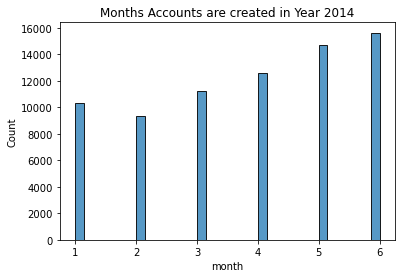

In [25]:
# Also going to create a time elapsed variable to get at longer customers
import seaborn as sns
temp_data = df.select(fn.col("date_account_created"),fn.month(fn.col("date_account_created")).alias("month")).toPandas()
sns.histplot(data=temp_data, x="month")
plt.title('Months Accounts are created in Year 2014')

In [26]:
# Can treat this as a numeric variable since all months are in 2014.
df = df.withColumn(
    'date_account_created',
    fn.month(fn.col("date_account_created")).alias("month")
)

In [27]:
#Need to rename the variable 'booked' to 'label'
df = df.withColumn(
    'label',
    df['booked']
)

In [28]:
# Split data into train/test
seed = 123
train, test = df.randomSplit([.7,.3], seed)

In [29]:
# One hot encoding for gender, signup method, language, signup app
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Gender
gender_idx = StringIndexer(inputCol="gender", outputCol="gender_idx")
gender_ohe = OneHotEncoder(inputCol="gender_idx", outputCol="gender_vec")

# Signup method
signup_method_idx = StringIndexer(inputCol="signup_method", outputCol="signup_method_idx")
signup_method_ohe = OneHotEncoder(inputCol="signup_method_idx", outputCol="signup_method_vec")

# Language
language_idx = StringIndexer(inputCol="language", outputCol="language_idx")
language_ohe = OneHotEncoder(inputCol="language_idx", outputCol="language_vec")

# Signup app
signup_app_idx = StringIndexer(inputCol="signup_app", outputCol="signup_app_idx")
signup_app_ohe = OneHotEncoder(inputCol="signup_app_idx", outputCol="signup_app_vec")

### Alex Additions ###
# First Device Type - Perhaps people browsing on their computer may be more serious about buying vs casual browsing on phone
device_idx = StringIndexer(inputCol="first_device_type", outputCol="first_device_type_idx")
device_ohe = OneHotEncoder(inputCol="first_device_type_idx", outputCol="first_device_type_vec")

In [30]:
# Impute missing values with median
from pyspark.ml.feature import Imputer

# Age
imputer_age = Imputer(
    inputCol='age_new', 
    outputCol='age_new_imputed'
    ).setStrategy("median")

# Total time elapsed
imputer_total_elapsed = Imputer(
    inputCol='total_time_elapsed', 
    outputCol='total_time_elapsed_imputed'
    ).setStrategy("median")

In [34]:
df.columns 

['age',
 'gender',
 'signup_method',
 'language',
 'signup_app',
 'total_time_elapsed',
 'total_num_actions',
 'first_device_type',
 'date_account_created',
 'country_destination',
 'id',
 'booked',
 'age_new',
 'age_missing',
 'label']

## Data Visualization

Text(0.5, 1.0, 'Histogram of Age')

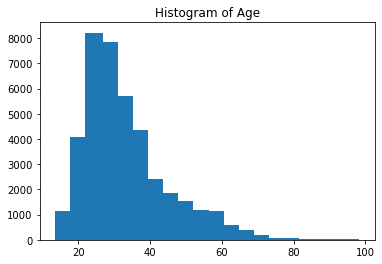

In [32]:
# Histogram of age
hists = df.select('age_new').rdd.flatMap(
    lambda row: row
).histogram(20)

data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data['bins'], data['freq'], width=5)
plt.title('Histogram of Age')

## Data Models

In this section we use selected features to predict in which country users booked a stay. We use numeric and dummy variables for logistic regression (ridge and lasso), as well as Naive B ....[XXXX]

In this section we use numerical features to predict whether a user will book or not with the AirBnB. We are using a simple logistic regression and compute probabilities.

In [ ]:
# Prepare the pipeline inputs

In [35]:
# Select features
features = ["age_new_imputed", "age_missing",
            "gender_vec", "signup_method_vec", "language_vec", "signup_app_vec",
             "total_time_elapsed_imputed", "total_num_actions", "first_device_type_vec", "date_account_created"]

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features,
                            outputCol="fts")

In [36]:
# Scale all features
from pyspark.ml.feature import MaxAbsScaler
# Using maxabsscaler because some OHE features are sparse
scaler = MaxAbsScaler(inputCol="fts", outputCol="features")

### Model 1: Logistic Regression 

In [80]:
# Setup logistic regression model
max_iterations = 10

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=max_iterations,
                        featuresCol = 'features',
                        labelCol = 'label',
                        regParam = 0.3,
                        elasticNetParam = 0.8 #penalized logistic regression elasticNetParam = 0.8
                        
                       )

In [81]:
# Configure pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[gender_idx, gender_ohe, 
                           signup_method_idx, signup_method_ohe,
                           language_idx, language_ohe,
                           signup_app_idx, signup_app_ohe, device_idx, device_ohe,
                           imputer_age, imputer_total_elapsed,
                           assembler, scaler,
                           lr])

In [82]:
# Train model
pipeline_model = pipeline.fit(train)

In [83]:
# Classify data in test set
predictions = pipeline_model.transform(test)

In [84]:
# Get AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="booked")
auc = evaluator.evaluate(predictions)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="booked", predictionCol="prediction")

In [56]:
# Get metrics
accuracy = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedRecall"})

In [57]:
# Get coefficients
coef = pipeline_model.stages[-1].coefficients

df_pred = predictions.select("probability", "prediction", "booked").toPandas()
df_pred.head()

,probability,prediction,booked
0,"[0.8839755548694519, 0.1160244451305481]",0.0,0
1,"[0.8632526309882185, 0.13674736901178153]",0.0,1
2,"[0.8642670848603585, 0.13573291513964147]",0.0,0
3,"[0.8597332611658636, 0.14026673883413643]",0.0,0
4,"[0.8543629259232044, 0.1456370740767956]",0.0,0


In [58]:
predictions.select("label", "features", "prediction", "probability").toPandas().head(5)

,label,features,prediction,probability
0,0,"(0.32, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0,"[0.8839755548694519, 0.1160244451305481]"
1,1,"(0.32, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0,"[0.8632526309882185, 0.13674736901178153]"
2,0,"(0.32, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0,"[0.8642670848603585, 0.13573291513964147]"
3,0,"(0.32, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0,"[0.8597332611658636, 0.14026673883413643]"
4,0,"(0.32, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0,"[0.8543629259232044, 0.1456370740767956]"


In [59]:
df_pred['prob_booked'] = df_pred['probability'].apply(lambda x: x[1])

In [60]:
import pandas as pd
df_pred['binned_pred'] = pd.qcut(df_pred['prob_booked'], q = 100, labels = False)

In [63]:
df_grpd.plot()
plt.xlabel('Predicted Percentile')
plt.ylabel('Percent Booked')
plt.title('Percent Booked by Model Prediction')

NameError: name 'df_grpd' is not defined

### Model 2: Ridge Regression

(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100,
regParam=0.1, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, standardization=True, solver="auto",
weightCol=None, aggregationDepth=2)

In [68]:
# Setup Ridge regression model
max_iterations = 10

from pyspark.ml.classification import LogisticRegression

lr_ridge = LogisticRegression(maxIter=max_iterations,
                              featuresCol="scaledFeatures", 
                              labelCol="booked",
                              regParam=0.1,
                              elasticNetParam=0.0, # Elastic Net Parameter (Ridge = 0, Lasso = 1, Elasticnet inbetween, penalty paramter) 
                              fitIntercept=True)

In [69]:
# Configure pipeline
from pyspark.ml import Pipeline
pipeline_ridge = Pipeline(stages=[gender_idx, gender_ohe, 
                           signup_method_idx, signup_method_ohe,
                           language_idx, language_ohe,
                           signup_app_idx, signup_app_ohe,
                           imputer_age, imputer_total_elapsed,
                           assembler, scaler,
                           lr_ridge])

In [70]:
# Train model
pipeline_ridge = pipeline.fit(train)

In [71]:
# Classify data in test set
predictions_ridge = pipeline_ridge.transform(test)

In [72]:
# Get AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="booked")
auc_ridge = evaluator.evaluate(predictions)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="booked", predictionCol="prediction")

In [73]:
# Get metrics
accuracy_ridge = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictions, {evaluatorMulti.metricName: "weightedRecall"})

In [74]:
# Get coefficients
coef_ridge = pipeline_ridge.stages[-1].coefficients

df_pred = predictions_ridge.select("probability", "prediction", "booked").toPandas()
df_pred.head()

,probability,prediction,booked
0,"[0.8839755548694519, 0.1160244451305481]",0.0,0
1,"[0.8632526309882185, 0.13674736901178153]",0.0,1
2,"[0.8642670848603585, 0.13573291513964147]",0.0,0
3,"[0.8597332611658636, 0.14026673883413643]",0.0,0
4,"[0.8543629259232044, 0.1456370740767956]",0.0,0


In [76]:
df_pred['prob_booked'] = df_pred['probability'].apply(lambda x: x[1])

In [77]:
import pandas as pd
df_pred['binned_pred'] = pd.qcut(df_pred['prob_booked'], q = 100, labels = False)

### Logistic and Ridge

In [85]:
import pandas as pd

pd.DataFrame({
    "Model" : [
        "Logistic",
        "Ridge",
        ],
    "AUC" : [
        auc,
        auc_ridge]
})

,Model,AUC
0,Logistic,0.500000
1,Ridge,0.761051


### Model 2: LASSO Regression

LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=100,
regParam=0.0, elasticNetParam=0.0, tol=1e-6, fitIntercept=True, standardization=True, solver="auto",
weightCol=None, aggregationDepth=2)

In [ ]:
# Setup Lasso regression model
max_iterations = 10

from pyspark.ml.classification import LogisticRegression

lr_ridge = LogisticRegression(maxIter=max_iterations,
                              featuresCol="scaledFeatures", 
                              labelCol="booked",
                              regParam=0.0,
                              elasticNetParam=1,
                              fitIntercept=True)

## Cross validation logistic regression

In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [1, 0.5, 0.1, 0.01, 0]) \
    .build()

print('-'*30)
print('paramGrid', paramGrid, '\n')
print('len(paramGrid): {}'.format(len(paramGrid)))
print('-'*30)

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed=1)
import time
t0 = time.time()
cv_model_lr = crossval.fit(df)
print("train time:", time.time() - t0)
print('-'*30)
print("elastic net 1", "to elastic net 0.01")
print(cv_model_lr.avgMetrics)

------------------------------
paramGrid [{Param(parent='LogisticRegression_5eb5731d22f4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}, {Param(parent='LogisticRegression_5eb5731d22f4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}, {Param(parent='LogisticRegression_5eb5731d22f4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1}, {Param(parent='LogisticRegression_5eb5731d22f4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.01}, {Param(parent='LogisticRegression_5eb5731d22f4', name='elasticNetParam', doc='the Ela

### Model 2: Random Forest 

In [92]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol = 'features',
    labelCol = 'label'
)

In [ ]:
pipeline_rf = Pipeline(stages=[gender_idx, gender_ohe, 
                           signup_method_idx, signup_method_ohe,
                           language_idx, language_ohe,
                           signup_app_idx, signup_app_ohe, device_idx, device_ohe,
                           imputer_age, imputer_total_elapsed,
                           assembler, scaler,
                           rf])

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 20, 50]) \
    .addGrid(rf.maxDepth, [3,5,6]) \
    .build()

print('-'*30)
print('paramGrid', paramGrid, '\n')
print('len(paramGrid): {}'.format(len(paramGrid)))
print('-'*30)

crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed=1)

t0 = time.time()
cv_model_rf = crossval.fit(df)
print("train time:", time.time() - t0)
print('-'*30)
print(cv_model_rf.avgMetrics)

------------------------------
paramGrid [{Param(parent='RandomForestClassifier_9c132f702e08', name='numTrees', doc='Number of trees to train (>= 1).'): 5, Param(parent='RandomForestClassifier_9c132f702e08', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3}, {Param(parent='RandomForestClassifier_9c132f702e08', name='numTrees', doc='Number of trees to train (>= 1).'): 5, Param(parent='RandomForestClassifier_9c132f702e08', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, {Param(parent='RandomForestClassifier_9c132f702e08', name='numTrees', doc='Number of trees to train (>= 1).'): 5, Param(parent='RandomForestClassifier_9c132f702e08', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 6}, {Param(parent='RandomForestClassif

### Model 3: Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(
    featuresCol = 'features',
    labelCol = 'label'
)

pipeline_bayes = Pipeline(stages=[gender_idx, gender_ohe, 
                           signup_method_idx, signup_method_ohe,
                           language_idx, language_ohe,
                           signup_app_idx, signup_app_ohe, device_idx, device_ohe,
                           imputer_age, imputer_total_elapsed,
                           assembler, scaler,
                           nb])

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0, 0.5, 1, 5]) \
    .build()

print('-'*30)
print('paramGrid', paramGrid, '\n')
print('len(paramGrid): {}'.format(len(paramGrid)))
print('-'*30)

crossval = CrossValidator(estimator=pipeline_bayes,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed=1)

t0 = time.time()
cv_model_bayes = crossval.fit(df)
print("train time:", time.time() - t0)
print('-'*30)
print(cv_model_bayes.avgMetrics)

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(
    featuresCol = 'features',
    labelCol = 'label',
    maxIter = 5
)

pipeline_gbt = Pipeline(stages=[gender_idx, gender_ohe, 
                           signup_method_idx, signup_method_ohe,
                           language_idx, language_ohe,
                           signup_app_idx, signup_app_ohe, device_idx, device_ohe,
                           imputer_age, imputer_total_elapsed,
                           assembler, scaler,
                           gbt])

# Set up the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 6]) \ # ER need to change AttributeError: 'GBTClassifier' object has no attribute 'max_depth' need to use 'maxDepth'
    .addGrid(gbt.minWeightFractionPerNode, [0, 0.01, 0.1]) \
    .build()

print('-'*30)
print('paramGrid', paramGrid, '\n')
print('len(paramGrid): {}'.format(len(paramGrid)))
print('-'*30)

crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          seed=1)

t0 = time.time()
cv_model_gbt = crossval.fit(df)
print("train time:", time.time() - t0)
print('-'*30)
print(cv_model_gbt.avgMetrics)

In [ ]:
import pandas as pd

# ER to check TypeError: 'int' object is not iterable

pd.DataFrame({
    "Model" : [
        "Lasso",
        "Ridge",
        "Naive Bayes",
        "Random Forest",
        "GBT"
    ],
    "AUC" : [
        cv_model_lr.avgMetrics[0],
        cv_model_lr.avgMetrics[max(len(cv_model_lr.avgMetrics))],
        max(cv_model_nb.avgMetrics),
        max(cv_model_rf.avgMetrics),
        max(cv_model_gbt.avgMetrics)
    ]
})

In [ ]:
import pandas as pd

# ER to check TypeError: 'int' object is not iterable

pd.DataFrame({
    "Model" : [
        "Logistic",
        "Ridge",
        "Naive Bayes",
        "Random Forest",
        "GBT"
    ],
    "AUC" : [
        auc,
        auc_ridge],
        max(cv_model_nb.avgMetrics),
        max(cv_model_rf.avgMetrics),
        max(cv_model_gbt.avgMetrics)
    ]
})